# Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.

Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [252]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        self.priors = Counter(train_classes)
        self.likelihoods = np.zeros(
            shape=(len(self.priors), train_features.shape[1], 4)
        )
        for features, result_class in zip(train_features, train_classes):
            for i, feature in enumerate(features):
                self.likelihoods[result_class, i, feature] += 1
        total = self.priors.total()
        for key in self.priors.keys():
            key_occurances = self.priors[key]
            self.priors[key] /= total
            for i in range(train_features.shape[1]):
                for j in range(4):
                    self.likelihoods[key, i, j] = (self.likelihoods[key, i, j] + 1) / (
                        key_occurances + 4
                    )

    def find_intervals(self, train_data):
        self.intervals = np.zeros(shape=(train_data.shape[1], 3))
        for i, features in enumerate(train_data.T):
            max_value = max(features)
            min_value = min(features)
            section_size = (max_value - min_value) / 4
            first_section_limit = min_value + section_size
            second_section_limit = first_section_limit + section_size
            third_section_limit = second_section_limit + section_size
            self.intervals[i] = np.array(
                [first_section_limit, second_section_limit, third_section_limit]
            )
            
    @staticmethod
    def data_discretization(data, intervals):
        discretize = (
            lambda x: 0
            if x < intervals[0]
            else 1
            if x < intervals[1]
            else 2
            if x < intervals[2]
            else 3
        )
        return [discretize(x) for x in data]

    def predict(self, sample):
        max_probability = 0
        prediction = None
        for key in self.priors.keys():
            probability = self.priors[key]
            for i, feature in enumerate(sample):
                probability *= self.likelihoods[key, i, feature]
            if probability > max_probability:
                prediction = key
                max_probability = probability
        return prediction


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        self.priors = Counter(train_classes)
        self.likelihoods = np.zeros(
            shape=(len(self.priors), train_features.shape[1], 2)
        )
        total = self.priors.total()
        for key in self.priors.keys():
            self.priors[key] /= total
            indices = np.where(train_classes == key)
            for i, feature in enumerate(train_features[indices].T):
                mean = np.mean(feature)
                deviation = np.std(feature, ddof=1)
                self.likelihoods[key, i, 0] = mean
                self.likelihoods[key, i, 1] = deviation

    @staticmethod
    def normal_dist(x, mean, std):
        return (
            1 / (std * np.sqrt(2 * np.sqrt(2 * np.pi))) * np.e ** (-0.5 * ((x - mean) / std) ** 2)
        )

    def predict(self, sample):
        max_probability = 0
        prediction = None
        for key in self.priors.keys():
            probability = self.priors[key]
            for i, feature in enumerate(sample):
                mean = self.likelihoods[key, i, 0]
                deviation = self.likelihoods[key, i, 1]
                probability *= GaussianNaiveBayes.normal_dist(feature, mean, deviation)
            if probability > max_probability:
                prediction = key
                max_probability = probability
        return prediction

# Experiments

In [253]:
iris = load_iris()

def run_naive_bayes(test_size, random_state, verbose = False, x = iris.data, y = iris.target):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )

    nb = NaiveBayes()
    nb.find_intervals(x_train)
    intervals = nb.intervals
    x_train = np.array([NaiveBayes.data_discretization(features, intervals[i]) for i, features in enumerate(x_train.T)]).T
    x_test = np.array([NaiveBayes.data_discretization(features, intervals[i]) for i, features in enumerate(x_test.T)]).T

    if verbose:
        print(f"Testing discrete naive bayes classifier")
        print(f"test size = {test_size}; random_state = {random_state}")
        print("result of classification of the test set:")
    good = 0
    total = 0
    nb = NaiveBayes()
    nb.build_classifier(x_train, y_train)
    for test_x, test_y in zip(x_test, y_test):
        prediction = nb.predict(test_x)
        if verbose:
            print(f"Prediction: {prediction}, True class: {test_y}")
        if prediction == test_y:
            good += 1
        total += 1
    if verbose:
        print(f"Accuracy: {good/total:.3f}")
    return good/total

def run_gaussian_naive_bayes(test_size, random_state, verbose = False):
    x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_state
)
    if verbose:
        print(f"Testing gaussian naive bayes classifier")
        print(f"test size = {test_size}; random_state = {random_state}")
        print("result of classification of the test set:")
    good = 0
    total = 0
    gaussian_naive_bayes = GaussianNaiveBayes()
    gaussian_naive_bayes.build_classifier(x_train, y_train)
    
    for test_x, test_y in zip(x_test, y_test):
        prediction = gaussian_naive_bayes.predict(test_x)
        if verbose:
            print(f"Prediction: {prediction}, True class: {test_y}")
        if prediction == test_y:
            good += 1
        total += 1
    if verbose:
        print(f"Accuracy: {good/total:.3f}")
    return good/total

In [254]:
result_of_naive_bayes = run_naive_bayes(0.1, 123, verbose=True)

Testing discrete naive bayes classifier
test size = 0.1; random_state = 123
result of classification of the test set:
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 1, True class: 2
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 2, True class: 2
Accuracy: 0.933


In [255]:
result_of_gaussian_naive_bayes = run_gaussian_naive_bayes(0.1, 123, verbose=True)

Testing gaussian naive bayes classifier
test size = 0.1; random_state = 123
result of classification of the test set:
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 2, True class: 2
Accuracy: 1.000


## Additional tests with different random states

In [272]:
for i in range(250, 253):
    run_naive_bayes(0.1, i, verbose=True)
    print("\n")

Testing discrete naive bayes classifier
test size = 0.1; random_state = 250
result of classification of the test set:
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 2, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 1, True class: 1
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 1, True class: 2
Accuracy: 0.867


Testing discrete naive bayes classifier
test size = 0.1; random_state = 251
result of classification of the test set:
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 2, True c

In [273]:
for i in range(250, 253):
    run_gaussian_naive_bayes(0.1, i, verbose=True)
    print("\n")

Testing gaussian naive bayes classifier
test size = 0.1; random_state = 250
result of classification of the test set:
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 1, True class: 1
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 1, True class: 2
Accuracy: 0.933


Testing gaussian naive bayes classifier
test size = 0.1; random_state = 251
result of classification of the test set:
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 2, True class: 2
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 0, True class: 0
Prediction: 1, True class: 1
Prediction: 0, True class: 0
Prediction: 2, True class: 2
Prediction: 1, True class: 1
Prediction: 1, True c

## Testing different test sizes

In [256]:
print("Testing Naive Bayes Classifier:\n")
for test_size in range(1, 19, 1):    
    print(f"test size: {test_size / 20}, Accuracy: {run_naive_bayes(test_size/20, 0):.3f}")

Testing Naive Bayes Classifier:

test size: 0.05, Accuracy: 1.000
test size: 0.1, Accuracy: 0.933
test size: 0.15, Accuracy: 0.957
test size: 0.2, Accuracy: 0.933
test size: 0.25, Accuracy: 0.921
test size: 0.3, Accuracy: 0.933
test size: 0.35, Accuracy: 0.925
test size: 0.4, Accuracy: 0.883
test size: 0.45, Accuracy: 0.882
test size: 0.5, Accuracy: 0.907
test size: 0.55, Accuracy: 0.904
test size: 0.6, Accuracy: 0.911
test size: 0.65, Accuracy: 0.898
test size: 0.7, Accuracy: 0.905
test size: 0.75, Accuracy: 0.912
test size: 0.8, Accuracy: 0.900
test size: 0.85, Accuracy: 0.914
test size: 0.9, Accuracy: 0.889


In [257]:
print("Testing Gaussian Naive Bayes Classifier:\n")
for test_size in range(1, 19, 1):   
    print(f"test size: {test_size / 20}, Accuracy: {run_gaussian_naive_bayes(test_size/20, 1):.3f}")

Testing Gaussian Naive Bayes Classifier:

test size: 0.05, Accuracy: 1.000
test size: 0.1, Accuracy: 1.000
test size: 0.15, Accuracy: 0.957
test size: 0.2, Accuracy: 0.967
test size: 0.25, Accuracy: 0.974
test size: 0.3, Accuracy: 0.956
test size: 0.35, Accuracy: 0.943
test size: 0.4, Accuracy: 0.950
test size: 0.45, Accuracy: 0.956
test size: 0.5, Accuracy: 0.960
test size: 0.55, Accuracy: 0.976
test size: 0.6, Accuracy: 0.967
test size: 0.65, Accuracy: 0.969
test size: 0.7, Accuracy: 0.962
test size: 0.75, Accuracy: 0.965
test size: 0.8, Accuracy: 0.933
test size: 0.85, Accuracy: 0.945
test size: 0.9, Accuracy: 0.956


In [258]:
import matplotlib.pyplot as plt


In [259]:
def create_scatter_plots(tested_seeds):
    test_sizes = np.array(range(5, 85, 2))
    test_sizes = test_sizes / 100
    accuracies_nb = np.zeros(40)
    accuracies_gnb = np.zeros(40)
    for i in range(tested_seeds):
        for j, test_size in enumerate(test_sizes):
            accuracies_nb[j] += run_naive_bayes(test_size, i)
            accuracies_gnb[j] += run_gaussian_naive_bayes(test_size, i)
    accuracies_nb /= tested_seeds
    accuracies_gnb /= tested_seeds
    fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(13,6.15))
    fig.text(0.25, 0 ,f"Average accuracies for {tested_seeds} cases")
    ax[0].scatter(test_sizes, accuracies_nb, color="green")
    ax[0].set_xlabel("Test size (fraction of the whole data set)")
    ax[0].set_ylabel("Average accuracy")
    ax[0].set_xlim(0.0, 0.9)
    ax[0].set_ylim(0.9, 0.97)
    ax[0].set_title(f"Accuracy of Discrete Naive Bayes Classyfier")
    ax[1].scatter(test_sizes, accuracies_gnb)
    ax[1].set_xlabel("Test size (fraction of the whole data set)")
    ax[1].set_ylabel("Average accuracy")
    ax[1].set_xlim(0.0, 0.9)
    ax[1].set_ylim(0.9, 0.97)
    ax[1].set_title(f"Accuracy of Gaussian Naive Bayes Classyfier")
    plt.show()


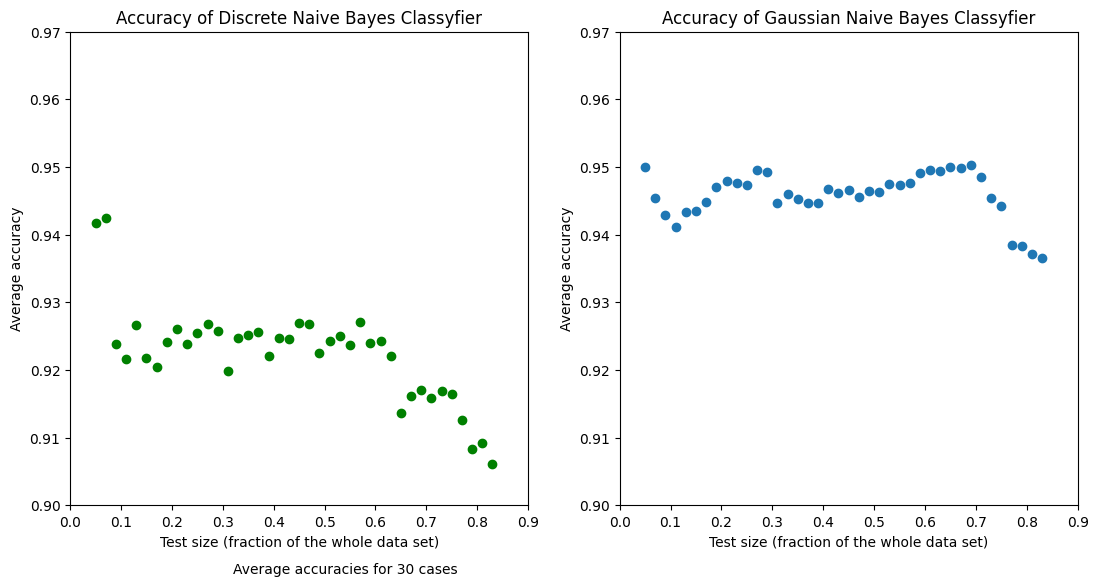

In [261]:
create_scatter_plots(30)

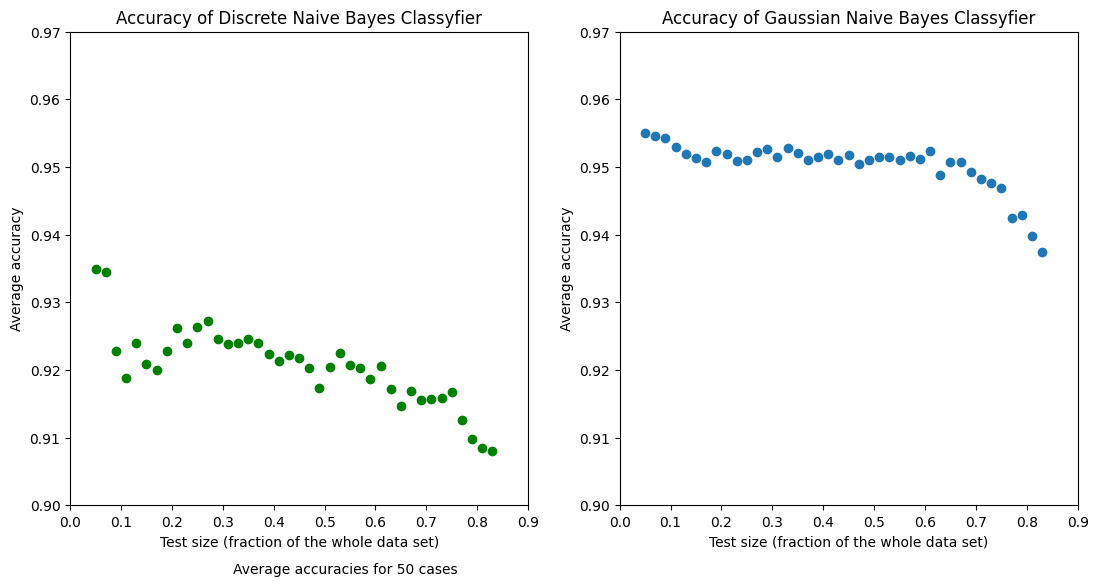

In [262]:
create_scatter_plots(50)

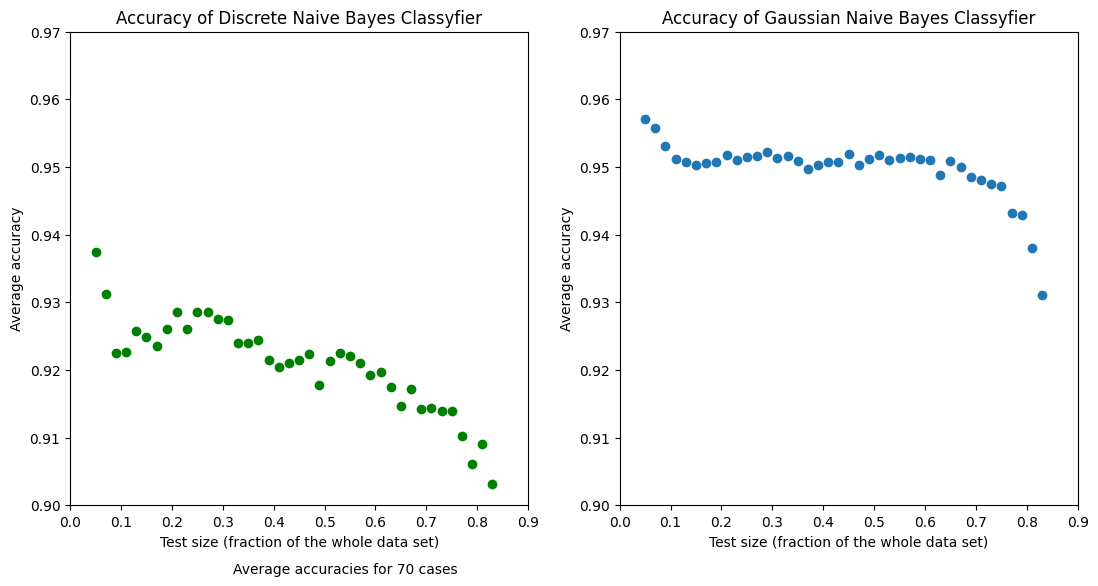

In [263]:
create_scatter_plots(70)

# Wnioski

Naiwny klasyfikator bayesowski jest względnie prostą metodą klasyfikacji, która do trenowania modelu wykorzystuje twierdzenie Bayesa. Model dość dobrze sprawdza się dla nieskomplikowanych zbiorów danych. Klasyfikator lepiej sprawdza się na zbiorach danych, których różne pola są ze sobą mało skorelowane (im mniej zależne tym lepiej).

W wersji naiwnej model działa dobrze, o ile podział atrybutów na klasy jest odpowidni, tzn. klas jest odpowiednio wiele, aby przydział do danej klasy dawał znaczącą informację. Jednak klas nie powinno być zbyt wiele, gdyż model będzie potrzebował odpowiednio więcej danych dla wszystkich klas do wytrenowania.

W wersji gaussowskiej zakładamy, że wszystkie atrybuty przyjmują postać rozkładu normalnego, co być może jest spełnione dla zbioru danych Iris, lecz nie będzie to prawdą dla każdego zbioru. W przypadku braku spełnienia tego kryterium, model nie będzie działa i dlatego, jeśli atrybut jest ciągły, odpowiedni dobór rozkładu jest niezbędny do sukcesu.

Mimo swojej prostoty, naiwny klasyfikator bayesowski przy odpowiednim doborze parametrów może osiągać dobre rezultaty, nawet przy niedużym rozmiarze zbioru trenującego. Jednak ze względu na założenia, które nie zawsze będą spełnione (niezależność atrybutów, rozkład atrybutu w całym zbiorze zgodny z rozkładem w zbiorze trenującym), bardziej skomplikowane modele, w przypadku ogólnym, będą osiągały lepsze rezultaty.